In [1]:
%%capture
!pip install unsloth vllm

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
from unsloth import FastLanguageModel, PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)

Unsloth: UnslothBCOTrainer is already patched.
Unsloth: UnslothCPOTrainer is already patched.
Unsloth: UnslothDPOTrainer is already patched.
Unsloth: UnslothGKDTrainer is already patched.
Unsloth: UnslothGRPOTrainer is already patched.
Unsloth: UnslothKTOTrainer is already patched.
Unsloth: UnslothNashMDTrainer is already patched.
Unsloth: UnslothOnlineDPOTrainer is already patched.
Unsloth: UnslothORPOTrainer is already patched.
Unsloth: UnslothPPOTrainer is already patched.
Unsloth: UnslothPRMTrainer is already patched.
Unsloth: UnslothRewardTrainer is already patched.
Unsloth: UnslothRLOOTrainer is already patched.
Unsloth: UnslothSFTTrainer is already patched.
Unsloth: UnslothXPOTrainer is already patched.


In [5]:
from unsloth import is_bfloat16_supported
import torch
max_seq_length = 1024

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-0.6B",
    max_seq_length = max_seq_length,
    load_in_4bit = False, 
    load_in_8bit = True,
    max_lora_rank = 1,
    gpu_memory_utilization = 0.8, 
)

==((====))==  Unsloth 2025.12.9: Fast Qwen3 patching. Transformers: 4.57.3. vLLM: 0.13.0.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [6]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 1, 
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ], 
    lora_alpha = 32,
    use_gradient_checkpointing = "unsloth", 
    use_rslora = False,
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.model` require gradients


In [7]:
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

In [8]:
import re
from datasets import load_dataset, Dataset

In [9]:
def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

In [10]:
def get_gsm8k_questions(split = "train") -> Dataset:
    data = load_dataset('openai/gsm8k', 'main')[split] 
    data = data.map(lambda x: { 
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }) 
    return data 

In [11]:
dataset = get_gsm8k_questions()

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [12]:
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

In [13]:
from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    loss_type = "grpo",
    lr_scheduler_type = "cosine",
    optim = "adamw_8bit",
    logging_steps = 1,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1, 
    num_generations = 6, 
    max_prompt_length = 256,
    max_completion_length = 200,
    max_steps = 200,
    save_steps = 200,
    max_grad_norm = 0.1,
    report_to = "none", 
    output_dir = "outputs",
)

Unsloth: We now expect `per_device_train_batch_size` * `gradient_accumulation_steps` * `world_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 6


In [14]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)

In [15]:
trainer_output = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,473 | Num Epochs = 1 | Total steps = 200
O^O/ \_/ \    Batch size per device = 6 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (6 x 1 x 1) = 6
 "-____-"     Trainable parameters = 630,784 of 596,680,704 (0.11% trained)
`generation_config` default values have been modified to match model-specific defaults: {'max_length': 40960, 'temperature': 0.6, 'top_p': 0.95}. If this is not desired, please set these values explicitly.


Unsloth: Will smartly offload gradients to save VRAM!
-------------------- Question:
A concert ticket costs $40. Mr. Benson bought 12 tickets and received a 5% discount for every ticket bought that exceeds 10. How much did Mr. Benson pay in all? 
Answer:
476 
Response:
<think>
Okay, let's see. Mr. Benson bought 12 concert tickets. The ticket price is $40. But he got a 5% discount for every ticket he bought that exceeds 10. So first, I need to figure out how many tickets he got a discount on.

He bought 12 tickets. The discount applies to tickets beyond the 10. So that means the first 10 are free? Wait, no, the discount is for every ticket that exceeds 10. So if he bought 12, then the first 10 are free? Or does it apply to each ticket beyond 10? Hmm. Wait, the wording is "received a 5% discount for every ticket bought that exceeds 10." So each ticket that exceeds 10 gets a 5% discount. So if he bought 12 tickets, how many of them are over 10? Well, 12 
Extracted:
<think>
Okay, let's see

Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,rewards / xmlcount_reward_func / mean,rewards / xmlcount_reward_func / std,rewards / soft_format_reward_func / mean,rewards / soft_format_reward_func / std,rewards / strict_format_reward_func / mean,rewards / strict_format_reward_func / std,rewards / int_reward_func / mean,rewards / int_reward_func / std,rewards / correctness_reward_func / mean,rewards / correctness_reward_func / std
1,0.000000,0.000000,0.000000,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,-0.000000,0.458333,1.122683,188.500000,131.000000,200.000000,0.833333,131.000000,131.000000,131.000000,No Log,No Log,No Log,No Log,No Log,0.000000,0.041667,0.102062,0.000000,0.000000,0.000000,0.000000,0.083333,0.204124,0.333333,0.816497
6,0.000000,0.000000,0.000000,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.009426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.002083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.248000,0.388875,138.666672,72.000000,200.000000,0.500000,77.333336,72.000000,87.000000,No Log,No Log,No Log,No Log,No Log,0.005520,0.081333,0.130731,0.000000,0.000000,0.000000,0.000000,0.166667,0.258199,0.000000,0.000000
9,0.000000,0.000000,0.000000,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.001889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,200.000000,200.000000,200.000000,1.000000,0.000000,0.000000,0.000000,No Log,No Log,No Log,No Log,No Log,0.001731,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


-------------------- Question:
Jane is trying to decide whether to buy a house or a trailer. A house costs $480,000 and a trailer costs $120,000. Each loan will be paid in monthly installments over 20 years. How much more is the monthly payment on the house compared to the trailer? 
Answer:
1500 
Response:
<think>
Okay, let's see. Jane wants to decide between buying a house or a trailer. The house costs $480,000 and the trailer is $120,000. Both have monthly payments over 20 years. The question is asking how much more the monthly payment on the house is compared to the trailer.

First, I need to figure out the monthly mortgage payments for both options. Since the loans are paid over 20 years, I should use the standard mortgage formula. The formula for the monthly payment on a fixed-rate mortgage is:

M = P * [i(1 + i)^n] / [(1 + i)^n - 1]

Where:
- M is the monthly payment
- P is the principal loan amount
- i is the monthly interest rate
- n is the number of payments (loan term in mont

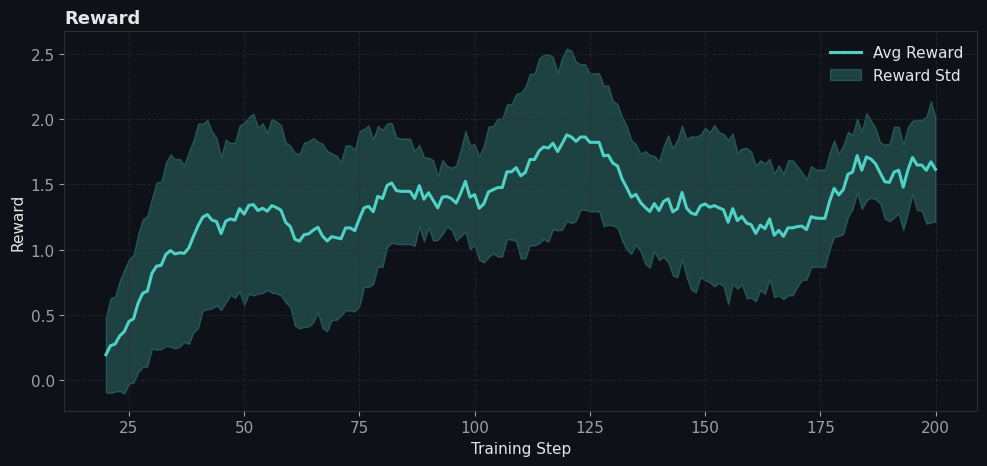

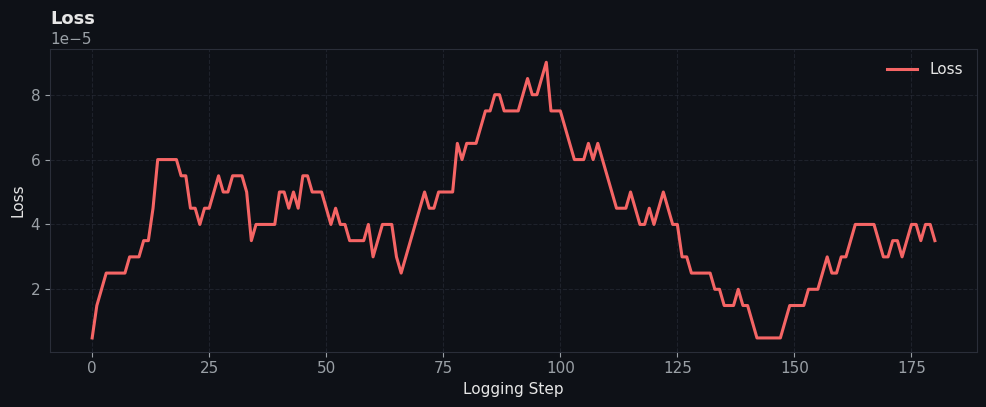

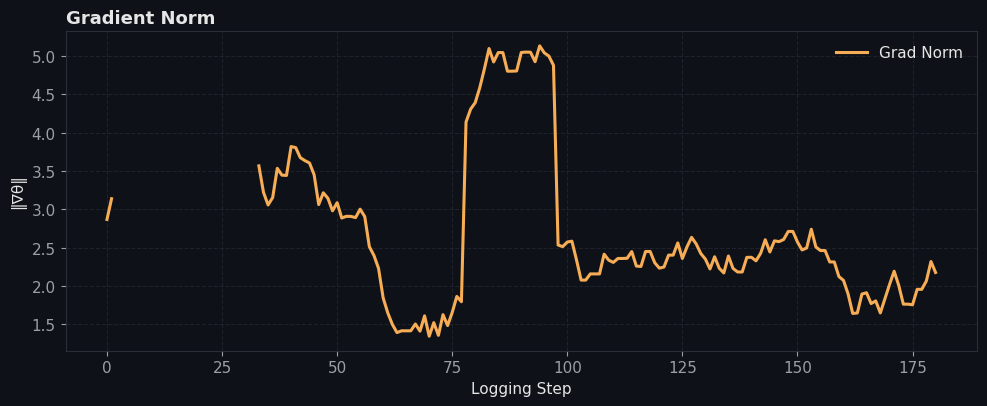

In [17]:
# ===============================
# TRL · W&B-Style Training Plots
# ===============================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# -------------------------------
# 1) Global W&B-like dark theme
# -------------------------------
rcParams.update({
    "figure.facecolor": "#0e1117",
    "axes.facecolor": "#0e1117",
    "axes.edgecolor": "#2a2e39",
    "axes.labelcolor": "#e6e6e6",
    "text.color": "#e6e6e6",
    "xtick.color": "#9aa0a6",
    "ytick.color": "#9aa0a6",
    "grid.color": "#2a2e39",
    "grid.linestyle": "--",
    "grid.alpha": 0.6,
    "axes.grid": True,
    "font.size": 11,
    "lines.linewidth": 2.2,
})

# -------------------------------
# 2) Extract TRL log history
# -------------------------------
logs = trainer.state.log_history

steps = []
rewards = []
reward_stds = []
losses = []
grad_norms = []

for e in logs:
    step = e.get("step")

    if step is not None and "reward" in e:
        steps.append(step)
        rewards.append(e["reward"])
        reward_stds.append(e.get("reward_std", 0.0))

    if "loss" in e:
        losses.append(e["loss"])

    if "grad_norm" in e:
        grad_norms.append(e["grad_norm"])

# Convert to numpy
rewards = np.array(rewards)
reward_stds = np.array(reward_stds)
losses = np.array(losses)
grad_norms = np.array(grad_norms)

# -------------------------------
# 3) Optional W&B-style smoothing
# -------------------------------
def smooth(x, window=20):
    if len(x) < window:
        return x
    kernel = np.ones(window) / window
    return np.convolve(x, kernel, mode="valid")

SMOOTH = True
WINDOW = 20

if SMOOTH:
    rewards_s = smooth(rewards, WINDOW)
    reward_stds_s = smooth(reward_stds, WINDOW)
    losses_s = smooth(losses, WINDOW)
    grad_norms_s = smooth(grad_norms, WINDOW)

    steps_s = steps[-len(rewards_s):]
else:
    rewards_s, reward_stds_s = rewards, reward_stds
    losses_s, grad_norms_s = losses, grad_norms
    steps_s = steps

# -------------------------------
# 4) Reward + Std (main signal)
# -------------------------------
if len(rewards_s) > 0:
    plt.figure(figsize=(10, 4.8))

    plt.plot(
        steps_s,
        rewards_s,
        color="#4fd1c5",
        label="Avg Reward"
    )

    plt.fill_between(
        steps_s,
        rewards_s - reward_stds_s,
        rewards_s + reward_stds_s,
        color="#4fd1c5",
        alpha=0.25,
        label="Reward Std"
    )

    plt.xlabel("Training Step")
    plt.ylabel("Reward")
    plt.title("Reward", loc="left", fontsize=13, weight="bold")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig("reward.png", dpi=150)
    plt.show()

# -------------------------------
# 5) Loss curve
# -------------------------------
if len(losses_s) > 0:
    plt.figure(figsize=(10, 4.2))

    plt.plot(
        losses_s,
        color="#f56565",
        label="Loss"
    )

    plt.xlabel("Logging Step")
    plt.ylabel("Loss")
    plt.title("Loss", loc="left", fontsize=13, weight="bold")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig("loss.png", dpi=150)
    plt.show()

# -------------------------------
# 6) Gradient Norm
# -------------------------------
if len(grad_norms_s) > 0:
    plt.figure(figsize=(10, 4.2))

    plt.plot(
        grad_norms_s,
        color="#f6ad55",
        label="Grad Norm"
    )

    plt.xlabel("Logging Step")
    plt.ylabel("‖∇θ‖")
    plt.title("Gradient Norm", loc="left", fontsize=13, weight="bold")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig("grad_norm.png", dpi=150)
    plt.show()
